In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import os

import sys
sys.path.insert(0, '../trainingdata')
from datasaver import *
sys.path.insert(0, '../testproblems/darcy')
from manufacturedsolutions import *
sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from NeuralOperator import NeuralOperator
from customlosses import *
from quadrature import *
from customlayers import discretize_functions
from basisfunctions import *

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cpu'

sublogdir = 'basisfunctions/Bsplines'
Bsplines = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'basisfunctions/Chebyshev'
Chebyshev = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'basisfunctions/Fourier'
Fourier = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'basisfunctions/Lagrange'
Lagrange = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'basisfunctions/POD'
POD = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'basisfunctions/polynomial'
polynomial = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'basisfunctions/sinc'
sinc = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

modeldict = {'POD': POD,
             'Chebyshev': Chebyshev,
            'B-splines': Bsplines,
             'Lagrange': Lagrange,
             'Polynomial': polynomial,
             'Fourier': Fourier,
             'Sinc': sinc}

/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_0 = torch.tensor(A_0, dtype=self.hparams['dtype'], device=self.used_device)
/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../ml/basisfunctions.py:237: RuntimeWarning: divide by zero encountered in power
  basis_gradients = self.exponents[None,:]*x[:,None]**(self.exponents-1)
/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../ml/basisfunctions.py:237: RuntimeWarning: invalid value encountered in multiply
  basis_gradients = self.exponents[None,:]*x[:,None]**(self.exponents-1)
/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../ml/basisfunctions.py:165: RuntimeWarning: invalid value encountered in divide
  output = np.sin(x)/x
/data/sto

/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../ml/customlayers.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=dtype, device=device)
/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:319: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F = torch.tensor(self.compute_F(theta, theta_g), dtype=self.hparams['dtype'], device=self.used_device)
/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:320: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

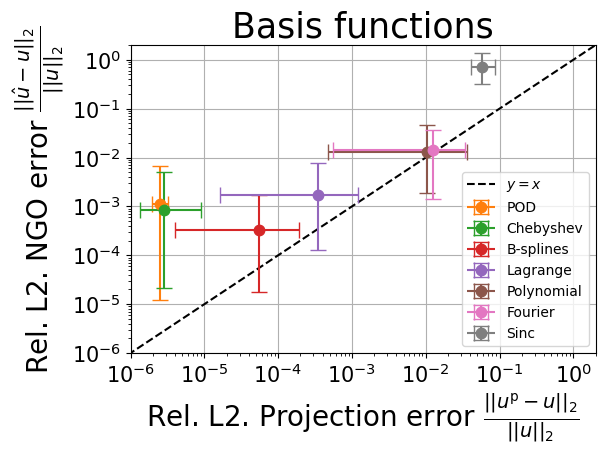

In [18]:
N_samples = 1000

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

# L2_scaled_avg = np.zeros(len(modeldict))
# L2_scaled_avg_proj = np.zeros(len(modeldict))
# yerr = np.zeros((2,len(modeldict)))
# xerr = np.zeros((2,len(modeldict)))

size_title = 25
size_ticklabels = 15
size_axeslabels = 20

# quadrature = GaussLegendreQuadrature2D(n_elements=1, Q=100)
quadrature = UniformQuadrature2D(Q=100)
x = torch.tensor(quadrature.xi_Omega, device=device)
w = torch.tensor(quadrature.w_Omega, device=device)

linestyles=['--','--','--','--','--','--','--','--']
colors = ['C0','C1','C2','C3','C4','C5','C6','C7']
# markers = ['o','^','o','^','o','^','o']

dataset = ManufacturedSolutionsSetDarcy(N_samples=N_samples, variables=['x','x'], l_min=[0.5,1], l_max=[0.5,1], device=device)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
plots.append(ax.plot(np.linspace(0,2,100),np.linspace(0,2,100), color='black', linestyle='--', label=r'$y=x$'))

m=0
for model in modeldict:
    u_exact = discretize_functions(u, x, dtype=modeldict[str(model)].hparams['dtype'], device=device)

    u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, x, u).detach().cpu().numpy()
    L2_scaled_array = weightedrelativeL2_set(w.detach().cpu().numpy(), u_hat, u_exact)
    L2_scaled_avg = np.average(L2_scaled_array)
    q_l = np.quantile(L2_scaled_array, q_low)
    q_h = np.quantile(L2_scaled_array, q_high)
    yerr = np.array([L2_scaled_avg - q_l, -L2_scaled_avg + q_h])

    u_proj = modeldict[str(model)].projection_forward(u).detach().cpu().numpy()
    L2_scaled_array_proj = weightedrelativeL2_set(w.detach().cpu().numpy(), u_proj, u_exact)
    L2_scaled_avg_proj = np.average(L2_scaled_array_proj)
    q_l_proj = np.quantile(L2_scaled_array_proj, q_low)
    q_h_proj = np.quantile(L2_scaled_array_proj, q_high)
    xerr = np.array([L2_scaled_avg_proj - q_l_proj, -L2_scaled_avg_proj + q_h_proj])

    m+=1
    
    plots.append(ax.errorbar(L2_scaled_avg_proj, L2_scaled_avg, xerr=xerr[:,None], yerr=yerr[:,None], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))

plt.legend(fontsize=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e-6,2e0)
ax.set_ylim(1e-6,2e0)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
# ax.set_xticklabels([r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_xlabel(r'Rel. L2. Projection error $\frac{||u^{\mathrm{p}}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2. NGO error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.grid()
ax.set_title('Basis functions', fontsize=size_title)

plt.savefig("basisfunctions.pdf", bbox_inches='tight')#, transparent=True)
plt.savefig("basisfunctions.svg", bbox_inches='tight')#, transparent=True)

plt.show()

In [109]:
from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cpu'

projection = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
projection.hparams['modeltype'] = 'projection'
projection.hparams['dtype'] = torch.float64
projection.hparams['precision'] = 64

sublogdir = 'systemnets/MLP'
MLP = loadmodelfromlabel(model=NeuralOperator, label='NN', logdir=logdir, sublogdir=sublogdir, device=device)
MLPmodelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'systemnets/ResNet'
ResNet = loadmodelfromlabel(model=NeuralOperator, label='NN', logdir=logdir, sublogdir=sublogdir, device=device)
ResNetmodelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'systemnets/U-Net'
UNet = loadmodelfromlabel(model=NeuralOperator, label='NN', logdir=logdir, sublogdir=sublogdir, device=device)
UNetmodelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'systemnets/FNO'
FNO = loadmodelfromlabel(model=NeuralOperator, label='NN', logdir=logdir, sublogdir=sublogdir, device=device)
FNOmodelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

# sublogdir = 'systemnets/MLP'
# MLP = loadmodelfromlabel(model=NeuralOperator, label='NN', logdir=logdir, sublogdir=sublogdir, device=device)
# MLPmodelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)



modeldict = {'Projection': projection,
            #  'MLP': MLP,
             'MLP model NGO': MLPmodelNGO,
            #  'ResNet': ResNet,
             'ResNet model NGO': ResNetmodelNGO,
            #  'U-Net': UNet,
             'U-Net model NGO': UNetmodelNGO,
            #  'FNO': FNO,
             'FNO model NGO': FNOmodelNGO

}

/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_0 = torch.tensor(A_0, dtype=self.hparams['dtype'], device=self.used_device)


RuntimeError: shape '[10, 1, 100, 100]' is invalid for input of size 392040

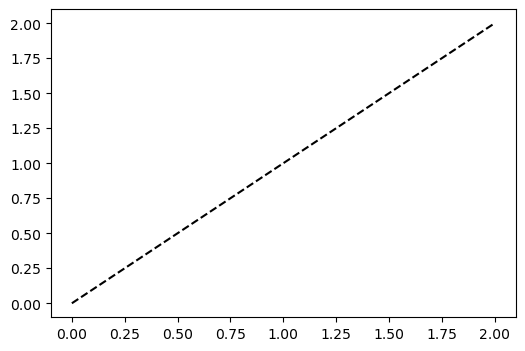

In [112]:
N_samples = 1000

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

# L2_scaled_avg = np.zeros(len(modeldict))
# L2_scaled_avg_proj = np.zeros(len(modeldict))
# yerr = np.zeros((2,len(modeldict)))
# xerr = np.zeros((2,len(modeldict)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

# quadrature = GaussLegendreQuadrature2D(n_elements=1, Q=100)
quadrature = UniformQuadrature2D(Q=100)
x = torch.tensor(quadrature.xi_Omega, device=device)
w = torch.tensor(quadrature.w_Omega, device=device)

linestyles=['--','--','--','--','--','--','--','--']
colors = ['C0','C1','C2','C3','C4','C5','C6','C7']
# markers = ['o','^','o','^','o','^','o']

dataset = ManufacturedSolutionsSetDarcy(N_samples=N_samples, variables=['x','x'], l_min=[0.5,1], l_max=[0.5,1], device=device)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
plots.append(ax.plot(np.linspace(0,2,100),np.linspace(0,2,100), color='black', linestyle='--', label=r'$y=x$'))

m=0
for model in modeldict:
    u_exact = discretize_functions(u, x, dtype=modeldict[str(model)].hparams['dtype'], device=device)
    
    u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, x, u).detach().cpu().numpy()
    L2_scaled_array = weightedrelativeL2_set(w.detach().cpu().numpy(), u_hat, u_exact)
    L2_scaled_avg = np.average(L2_scaled_array)
    q_l = np.quantile(L2_scaled_array, q_low)
    q_h = np.quantile(L2_scaled_array, q_high)
    yerr = np.array([L2_scaled_avg - q_l, -L2_scaled_avg + q_h])

    modeldict[str(model)].hparams['modeltype']='NN'
    # modeldict[str(model)].__init__(modeldict[str(model)].hparams)
    u_proj = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, x, u).detach().cpu().numpy()
    L2_scaled_array_proj = weightedrelativeL2_set(w.detach().cpu().numpy(), u_proj, u_exact)
    L2_scaled_avg_proj = np.average(L2_scaled_array_proj)
    q_l_proj = np.quantile(L2_scaled_array_proj, q_low)
    q_h_proj = np.quantile(L2_scaled_array_proj, q_high)
    xerr = np.array([L2_scaled_avg_proj - q_l_proj, -L2_scaled_avg_proj + q_h_proj])

    m+=2
    
    plots.append(ax.errorbar(L2_scaled_avg_proj, L2_scaled_avg, xerr=xerr[:,None], yerr=yerr[:,None], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))

plt.legend(fontsize=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e-6,2e0)
ax.set_ylim(1e-6,2e0)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
# ax.set_xticklabels([r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_xlabel(r'Projection error $\frac{||u^{\mathrm{p}}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_ylabel(r'NGO error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.grid()

plt.savefig("basisfunctions.pdf", bbox_inches='tight')#, transparent=True)
plt.savefig("basisfunctions.svg", bbox_inches='tight')#, transparent=True)

plt.show()